In [1]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

# **Reading the CSV files**

In [2]:
# Read the CSV file
filenames = ['sensex_1990_to_2014.csv',
             'nifty_1994_to_2014.csv',
             'nifty_2000_to_2024.csv']

file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_2000_to_2024.csv'

data = pd.read_csv(file_name)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,5291.749764,5336.862885,5241.120997,5290.119381,5290.119381,38655.058824
std,996.396802,989.287755,1003.653913,996.116806,996.116806,74383.681317
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000
25%,4882.237305,4935.449829,4835.637451,4887.637451,4887.637451,0.000000
50%,5342.224854,5382.899902,5297.350098,5334.349854,5334.349854,0.000000
75%,5888.749878,5923.625122,5844.474976,5889.887451,5889.887451,0.000000
max,7942.250000,7968.250000,7939.200195,7954.350098,7954.350098,437000.000000


# **Calculate the Technical Indicator**

In [4]:
# Define the parameters
sma_window_size = 3
ema_smoothing_param = 0.2
williams_r_window_size = 3
RSI_window_size = 14
ATR_window_size = 14
VR_window_size = 14

k_param = 10                 # Defining the k parameter for KNN algorithm
training_set_ratio = 0.9     # Defining the training set for KNN algorithm
enable_knn_normalization = True

In [5]:
def williams_r(highs, lows, closes, window):
    highest_high = highs.rolling(window=window).max()
    lowest_low = lows.rolling(window=window).min()
    r = ((highest_high - closes) / (highest_high - lowest_low)) * -100
    return r

def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, window):
    tr1 = data['High'] - data['Low']
    tr2 = abs(data['High'] - data['Close'].shift(1))
    tr3 = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def calculate_vr(data, window):
    tr = data['High'] - data['Low']
    tr_prev = tr.shift(1).rolling(window=window).mean()
    vr = tr / tr_prev
    return vr

def TI_calculations(data):
    data['returns'] = -data['Close'].diff(-1)
    #data['SMA_Close'] = data['Close'].rolling(window=sma_window_size).mean()
    #data['EMA_Close'] = data['Close'].ewm(alpha=ema_smoothing_param).mean()
    #data['Williams %R'] = williams_r(data['High'], data['Low'], data['Close'], window=williams_r_window_size)
    #data['RSI'] = calculate_rsi(data, window=RSI_window_size)
    #data['ATR'] = calculate_atr(data, window=ATR_window_size)
    #data['VR'] = calculate_vr(data, window=VR_window_size)
    data.drop(columns=['Date'],inplace=True)

    data['gain_or_loss'] = data['returns'].apply(lambda x: 1 if x > 0 else -1)   # For SVM
    
    # Remove non-numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    data.dropna(inplace = True)
    return data

data = TI_calculations(data)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,returns,gain_or_loss
1694,7875.350098,7919.649902,7855.950195,7891.100098,7891.100098,115200,22.100098,1
1695,7904.549805,7929.049805,7900.049805,7913.200195,7913.200195,104100,-6.900391,-1
1696,7931.750000,7968.250000,7897.950195,7906.299805,7906.299805,118500,-1.549805,-1
1697,7874.500000,7915.450195,7862.450195,7904.750000,7904.750000,142800,31.299805,1
1698,7933.899902,7946.850098,7916.549805,7936.049805,7936.049805,120000,18.300293,1


# **SVM Fitting**

In [6]:
def svm(data,query,enable_normalization = True):
    features = data.drop(columns=['returns', 'gain_or_loss'])
    query = query.drop(labels=['returns', 'gain_or_loss'])
    target = data['gain_or_loss']

    if enable_normalization:
        features = (features - features.min())/(features.max() - features.min())
        query = (query - features.min())/(features.max() - features.min())

    svm = SVC(C=0.01,gamma='scale')
    svm.fit(features, target)

    query = query.values.reshape(1,-1)    
    predicted_label = svm.predict(query)
    
    return predicted_label

# **KNN Search with euclidean distance metrics**

In [7]:
train_set_length = int(training_set_ratio*data.shape[0])     # 90% of the data is used for training

**Algorithm**

1) The data is normalized first.Normalization ensure that the distance between two point for attribute 1 is in the same scale as the distance between any other two points.The distances only will be in the range 0 to 1.
2) The euclidean distances of the current day price,TIs(query) are calculated with respect to all the element training set.
3) The whole dataset is then sorted based on this training set in ascending order and then the first 'k' row are returned

In [8]:
def knn_search(data,query,k,predicted_label,enable_normalization = enable_knn_normalization):

    # Scaling the data
    if enable_normalization:
        query = (query - data.min())/(data.max() - data.min())
        temp_data = (data - data.min())/(data.max() - data.min())
    else:
        temp_data = data

    query = query.drop(labels = ['gain_or_loss'])
    temp_data = temp_data.drop(columns = ['gain_or_loss'])
        
    neighbors_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neighbors_model.fit(temp_data)
    query = query.values.reshape(1,-1) 
    distances, indices = neighbors_model.kneighbors(query)

    # Get neighbors with the predicted label
    neighbors_indices = indices[0]
    filtered_indices = [idx for idx in neighbors_indices if data.iloc[idx]['gain_or_loss'] == predicted_label]

    return data.iloc[filtered_indices]

sorted_data = knn_search(data,data.iloc[-1,:],10,1)

In [9]:
sorted_data

,Open,High,Low,Close,Adj Close,Volume,returns,gain_or_loss
1698,7933.899902,7946.850098,7916.549805,7936.049805,7936.049805,120000,18.300293,1
1693,7915.799805,7922.700195,7864.049805,7875.299805,7875.299805,117300,15.800293,1
1694,7875.350098,7919.649902,7855.950195,7891.100098,7891.100098,115200,22.100098,1
1691,7785.250000,7880.500000,7779.200195,7874.250000,7874.250000,126700,23.250000,1
1697,7874.500000,7915.450195,7862.450195,7904.750000,7904.750000,142800,31.299805,1
1675,7794.899902,7809.200195,7752.899902,7795.750000,7795.750000,122100,34.850098,1


In [10]:
estimated_price_dictionary = {}
actual_price_dictionary = {}
for file in filenames:
    data = pd.read_csv(file)
    data = TI_calculations(data)
    
    actual_close_price = []
    estimated_close_price = []
    for i in tqdm(range(data.shape[0]-train_set_length-1),desc = f"Processing {file} : "):
        data_for_search = data.iloc[i:i+train_set_length,:]
        query = data.iloc[i+train_set_length,:]

        predicted_label = svm(data_for_search,query)
        
        sorted_data = knn_search(data_for_search,query,k_param,predicted_label)
        estimated_return = sorted_data['returns'].mean()
    
        estimated_close_price.append(query['Close'] + estimated_return)
        actual_close_price.append(data.iloc[i+train_set_length+1,:]['Close'])
        
    # Error metrics
    estimated_close_price = np.array(estimated_close_price)
    actual_close_price = np.array(actual_close_price)

    estimated_price_dictionary[file] = estimated_close_price
    actual_price_dictionary[file] = actual_close_price

Processing nifty_2000_to_2024.csv : 100%|███| 4438/4438 [08:35<00:00,  8.61it/s]


# **Visualization**

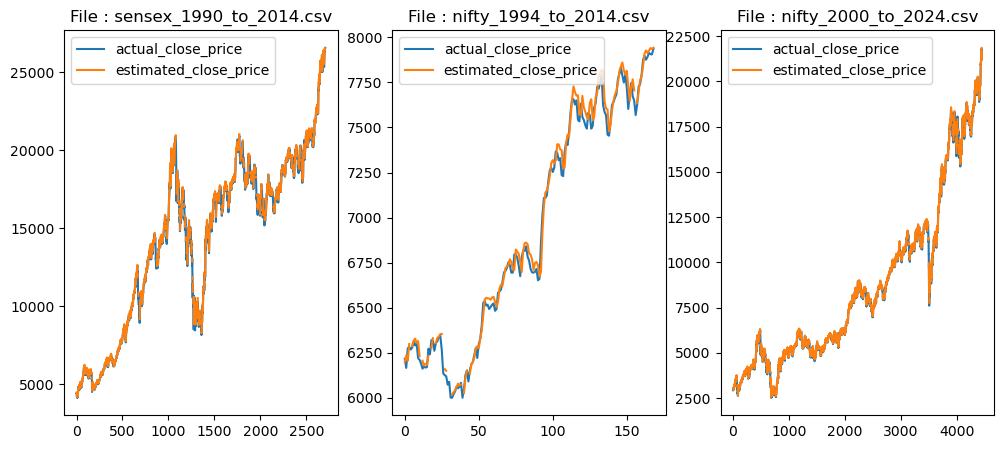

In [11]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]])
plt.plot(estimated_price_dictionary[filenames[0]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]])
plt.plot(estimated_price_dictionary[filenames[1]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]])
plt.plot(estimated_price_dictionary[filenames[2]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.show()

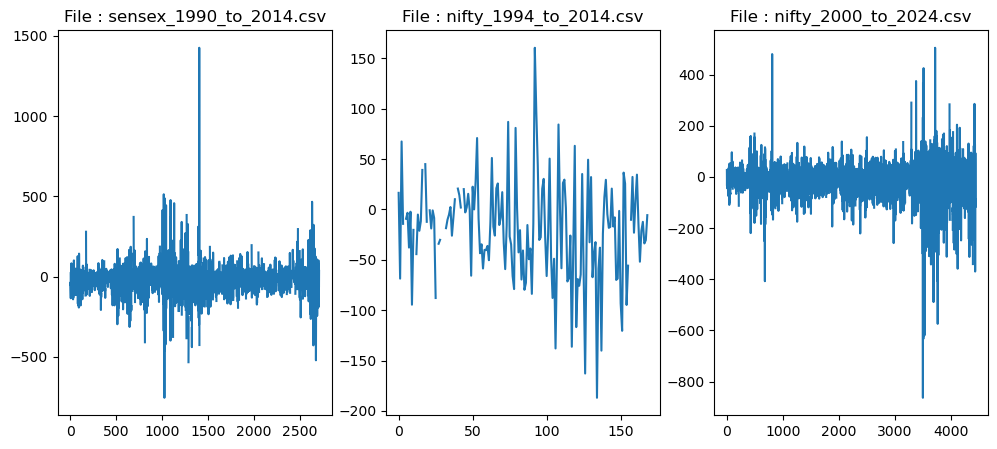

In [12]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]] - estimated_price_dictionary[filenames[0]])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]] - estimated_price_dictionary[filenames[1]])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]] - estimated_price_dictionary[filenames[2]])

plt.show()

In [13]:
for file in filenames:
    error = actual_price_dictionary[file] - estimated_price_dictionary[file]
    print(f"The rmse for {file} with enable_knn_normalization as {enable_knn_normalization} is {np.sqrt(np.mean(error**2))}")

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is nan
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is nan
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is nan


# **Result**

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 159.64546909787833 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 53.23747311008333 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 81.98897011394857 <br>

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as False is 218.31278041503953 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as False is 58.958624851545196 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as False is 78.8741215572352 <br>